Importing libraries

In [126]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import json

In [127]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Reading the files into training and validation datasets with a 80%-20% split

In [128]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/Augmented Dorsal Vein/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

Found 5516 files belonging to 138 classes.
Using 4413 files for training.
Using 1103 files for validation.


In [129]:
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)

In [130]:
def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"Total number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Total number of samples in train_dataset: 3520 (110 batches of 32)
Total number of samples in validation_dataset: 1120 (35 batches of 32)
Total number of samples in test_dataset: 864 (27 batches of 32)


Prefetching data into GPU memory to optimize training process

In [131]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Visualizing some training images

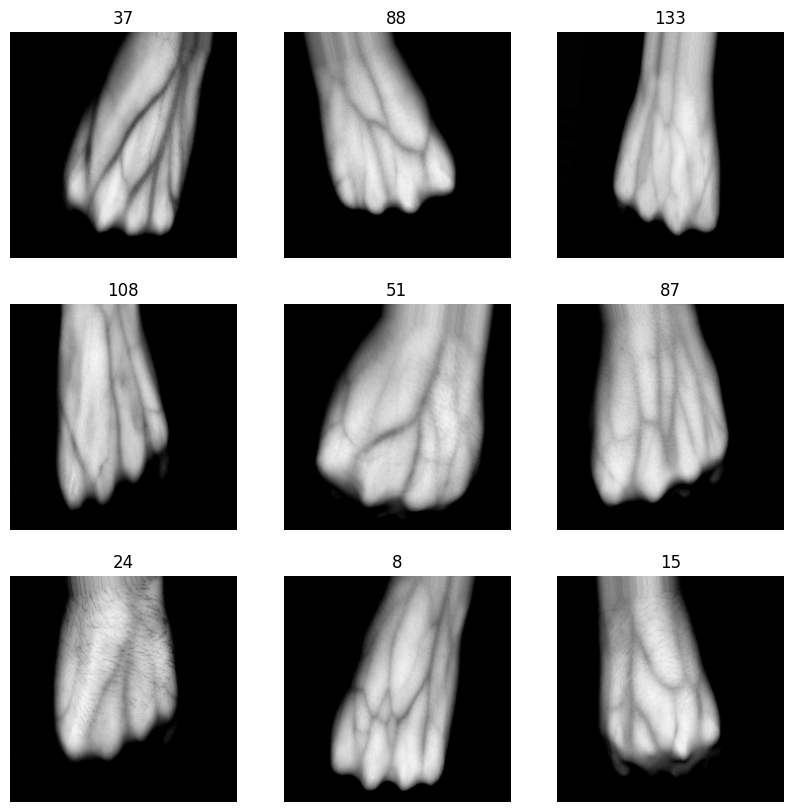

In [132]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Define some key constants

In [135]:
num_classes = 138
image_size = (224, 224, 3)

Defining function to return AlexNet Model with reduced number of filters as per research paper

In [136]:
def make_alexnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Layer 1: Convolutional + Max Pooling
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), strides=(4, 4), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 2: Convolutional + Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 3: Three Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


Defining function to return VGG16 Model with reduced number of filters as per research paper

In [137]:
def make_vgg16_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

Defining function to return VGG19 Model with reduced number of filters as per research paper

In [138]:
def make_vgg19_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


Training each model

In [146]:
from tqdm import tqdm
num_epochs = 30

models = {
    # "AlexNet": (make_alexnet_model(input_shape=image_size, num_classes=num_classes), 1e-4),
    # "VGG16": (make_vgg16_model(input_shape=image_size, num_classes=num_classes), 1e-4),
    "VGG19": (make_vgg19_model(input_shape=image_size, num_classes=num_classes), 1e-4),
}

model_histories = {}

for name, model in models.items():
    print(f'\x1b[34mTraining {name} Model...\x1b[0m')
    model[0].compile(
        optimizer=keras.optimizers.Adam(model[1]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    start = time.time()

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)
        
    # Wrap model.fit with tqdm for a progress bar
    progress_bar = tqdm(total=num_epochs, position=0, leave=True)
    history = model[0].fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)),
            reduce_lr
        ]
    )
    progress_bar.close()
    
    model_histories[name] = history
    
    end = time.time()
    print(f'Finished training {name} in {end-start:.2f}s\n')


Training VGG19 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 5.6120 - accuracy: 0.0165

  3%|▎         | 1/30 [00:29<14:26, 29.88s/it]

110/110 [==============================] - 30s 251ms/step - loss: 5.6120 - accuracy: 0.0165 - val_loss: 4.9872 - val_accuracy: 0.0054 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 4.5907 - accuracy: 0.0520

  7%|▋         | 2/30 [00:57<13:18, 28.50s/it]


Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
110/110 [==============================] - 28s 248ms/step - loss: 4.5907 - accuracy: 0.0520 - val_loss: 5.0446 - val_accuracy: 0.0190 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 3.7379 - accuracy: 0.1483

 10%|█         | 3/30 [01:25<12:38, 28.09s/it]

110/110 [==============================] - 28s 249ms/step - loss: 3.7379 - accuracy: 0.1483 - val_loss: 4.7051 - val_accuracy: 0.0481 - lr: 5.0000e-05
Epoch 4/30
110/110 [==============================] - ETA: 0s - loss: 3.0859 - accuracy: 0.2401

 13%|█▎        | 4/30 [01:52<12:05, 27.89s/it]

110/110 [==============================] - 28s 249ms/step - loss: 3.0859 - accuracy: 0.2401 - val_loss: 2.8699 - val_accuracy: 0.2774 - lr: 5.0000e-05
Epoch 5/30
110/110 [==============================] - ETA: 0s - loss: 2.4412 - accuracy: 0.3753

 17%|█▋        | 5/30 [02:20<11:34, 27.79s/it]

110/110 [==============================] - 28s 249ms/step - loss: 2.4412 - accuracy: 0.3753 - val_loss: 2.0830 - val_accuracy: 0.4760 - lr: 5.0000e-05
Epoch 6/30
110/110 [==============================] - ETA: 0s - loss: 1.8175 - accuracy: 0.5088

 20%|██        | 6/30 [02:47<11:05, 27.73s/it]

110/110 [==============================] - 28s 249ms/step - loss: 1.8175 - accuracy: 0.5088 - val_loss: 1.2629 - val_accuracy: 0.7099 - lr: 5.0000e-05
Epoch 7/30
110/110 [==============================] - ETA: 0s - loss: 1.2786 - accuracy: 0.6483

 23%|██▎       | 7/30 [03:16<10:43, 27.98s/it]


Epoch 7: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
110/110 [==============================] - 28s 257ms/step - loss: 1.2786 - accuracy: 0.6483 - val_loss: 1.4483 - val_accuracy: 0.5975 - lr: 5.0000e-05
Epoch 8/30
110/110 [==============================] - ETA: 0s - loss: 0.8235 - accuracy: 0.7710

 27%|██▋       | 8/30 [03:43<10:13, 27.88s/it]

110/110 [==============================] - 28s 249ms/step - loss: 0.8235 - accuracy: 0.7710 - val_loss: 0.6298 - val_accuracy: 0.8613 - lr: 2.5000e-05
Epoch 9/30
110/110 [==============================] - ETA: 0s - loss: 0.6080 - accuracy: 0.8372

 30%|███       | 9/30 [04:11<09:44, 27.81s/it]

110/110 [==============================] - 28s 250ms/step - loss: 0.6080 - accuracy: 0.8372 - val_loss: 0.4268 - val_accuracy: 0.9112 - lr: 2.5000e-05
Epoch 10/30
110/110 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.8776

 33%|███▎      | 10/30 [04:39<09:15, 27.78s/it]

110/110 [==============================] - 28s 250ms/step - loss: 0.4784 - accuracy: 0.8776 - val_loss: 0.3841 - val_accuracy: 0.9093 - lr: 2.5000e-05
Epoch 11/30
110/110 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.9017

 37%|███▋      | 11/30 [05:06<08:46, 27.73s/it]

110/110 [==============================] - 28s 249ms/step - loss: 0.3794 - accuracy: 0.9017 - val_loss: 0.3196 - val_accuracy: 0.9211 - lr: 2.5000e-05
Epoch 12/30
110/110 [==============================] - ETA: 0s - loss: 0.3084 - accuracy: 0.9185

 40%|████      | 12/30 [05:34<08:19, 27.73s/it]

110/110 [==============================] - 28s 250ms/step - loss: 0.3084 - accuracy: 0.9185 - val_loss: 0.2570 - val_accuracy: 0.9347 - lr: 2.5000e-05
Epoch 13/30
110/110 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 0.9256

 43%|████▎     | 13/30 [06:02<07:50, 27.68s/it]

110/110 [==============================] - 28s 249ms/step - loss: 0.2794 - accuracy: 0.9256 - val_loss: 0.2308 - val_accuracy: 0.9465 - lr: 2.5000e-05
Epoch 14/30
110/110 [==============================] - ETA: 0s - loss: 0.2072 - accuracy: 0.9469

 47%|████▋     | 14/30 [06:29<07:22, 27.66s/it]

110/110 [==============================] - 28s 249ms/step - loss: 0.2072 - accuracy: 0.9469 - val_loss: 0.1880 - val_accuracy: 0.9556 - lr: 2.5000e-05
Epoch 15/30
110/110 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9548

 50%|█████     | 15/30 [06:57<06:54, 27.65s/it]


Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
110/110 [==============================] - 28s 249ms/step - loss: 0.1771 - accuracy: 0.9548 - val_loss: 0.1959 - val_accuracy: 0.9556 - lr: 2.5000e-05
Epoch 16/30
110/110 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9670

 53%|█████▎    | 16/30 [07:25<06:27, 27.64s/it]

110/110 [==============================] - 28s 249ms/step - loss: 0.1466 - accuracy: 0.9670 - val_loss: 0.1340 - val_accuracy: 0.9701 - lr: 1.2500e-05
Epoch 17/30
110/110 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9773

 57%|█████▋    | 17/30 [07:52<05:59, 27.64s/it]


Epoch 17: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
110/110 [==============================] - 28s 249ms/step - loss: 0.1161 - accuracy: 0.9773 - val_loss: 0.1741 - val_accuracy: 0.9592 - lr: 1.2500e-05
Epoch 18/30
110/110 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.9798

 60%|██████    | 18/30 [08:20<05:31, 27.64s/it]

110/110 [==============================] - 28s 249ms/step - loss: 0.1104 - accuracy: 0.9798 - val_loss: 0.1154 - val_accuracy: 0.9710 - lr: 6.2500e-06
Epoch 19/30
110/110 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9793

 63%|██████▎   | 19/30 [08:48<05:05, 27.81s/it]

110/110 [==============================] - 28s 255ms/step - loss: 0.0993 - accuracy: 0.9793 - val_loss: 0.1113 - val_accuracy: 0.9773 - lr: 6.2500e-06
Epoch 20/30
110/110 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9830

 67%|██████▋   | 20/30 [09:16<04:37, 27.76s/it]

110/110 [==============================] - 28s 250ms/step - loss: 0.0881 - accuracy: 0.9830 - val_loss: 0.1068 - val_accuracy: 0.9728 - lr: 6.2500e-06
Epoch 21/30
110/110 [==============================] - ETA: 0s - loss: 0.0925 - accuracy: 0.9812

 70%|███████   | 21/30 [09:43<04:09, 27.73s/it]


Epoch 21: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
110/110 [==============================] - 28s 250ms/step - loss: 0.0925 - accuracy: 0.9812 - val_loss: 0.1107 - val_accuracy: 0.9737 - lr: 6.2500e-06
Epoch 22/30
110/110 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9881

 73%|███████▎  | 22/30 [10:11<03:41, 27.70s/it]

110/110 [==============================] - 28s 249ms/step - loss: 0.0800 - accuracy: 0.9881 - val_loss: 0.1015 - val_accuracy: 0.9773 - lr: 3.1250e-06
Epoch 23/30
110/110 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9838

 77%|███████▋  | 23/30 [10:39<03:13, 27.69s/it]

110/110 [==============================] - 28s 250ms/step - loss: 0.0836 - accuracy: 0.9838 - val_loss: 0.0989 - val_accuracy: 0.9801 - lr: 3.1250e-06
Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.9824

 80%|████████  | 24/30 [11:06<02:46, 27.68s/it]


Epoch 24: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
110/110 [==============================] - 28s 250ms/step - loss: 0.0790 - accuracy: 0.9824 - val_loss: 0.1036 - val_accuracy: 0.9755 - lr: 3.1250e-06
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9821

 83%|████████▎ | 25/30 [11:34<02:18, 27.68s/it]


Epoch 25: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
110/110 [==============================] - 28s 250ms/step - loss: 0.0771 - accuracy: 0.9821 - val_loss: 0.0990 - val_accuracy: 0.9755 - lr: 1.5625e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0785 - accuracy: 0.9855

 87%|████████▋ | 26/30 [12:02<01:50, 27.67s/it]

110/110 [==============================] - 28s 250ms/step - loss: 0.0785 - accuracy: 0.9855 - val_loss: 0.0967 - val_accuracy: 0.9782 - lr: 7.8125e-07
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9844

 90%|█████████ | 27/30 [12:29<01:22, 27.66s/it]

110/110 [==============================] - 28s 249ms/step - loss: 0.0812 - accuracy: 0.9844 - val_loss: 0.0958 - val_accuracy: 0.9764 - lr: 7.8125e-07
Epoch 28/30
110/110 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9841

 93%|█████████▎| 28/30 [12:57<00:55, 27.67s/it]

110/110 [==============================] - 28s 250ms/step - loss: 0.0745 - accuracy: 0.9841 - val_loss: 0.0949 - val_accuracy: 0.9773 - lr: 7.8125e-07
Epoch 29/30
110/110 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9886

 97%|█████████▋| 29/30 [13:25<00:27, 27.66s/it]

110/110 [==============================] - 28s 249ms/step - loss: 0.0717 - accuracy: 0.9886 - val_loss: 0.0945 - val_accuracy: 0.9773 - lr: 7.8125e-07
Epoch 30/30
110/110 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9878

100%|██████████| 30/30 [13:52<00:00, 27.66s/it]

110/110 [==============================] - 28s 250ms/step - loss: 0.0670 - accuracy: 0.9878 - val_loss: 0.0939 - val_accuracy: 0.9773 - lr: 7.8125e-07


100%|██████████| 30/30 [13:52<00:00, 27.76s/it]

Finished training VGG19 in 832.87s



Defining function to plot model performance

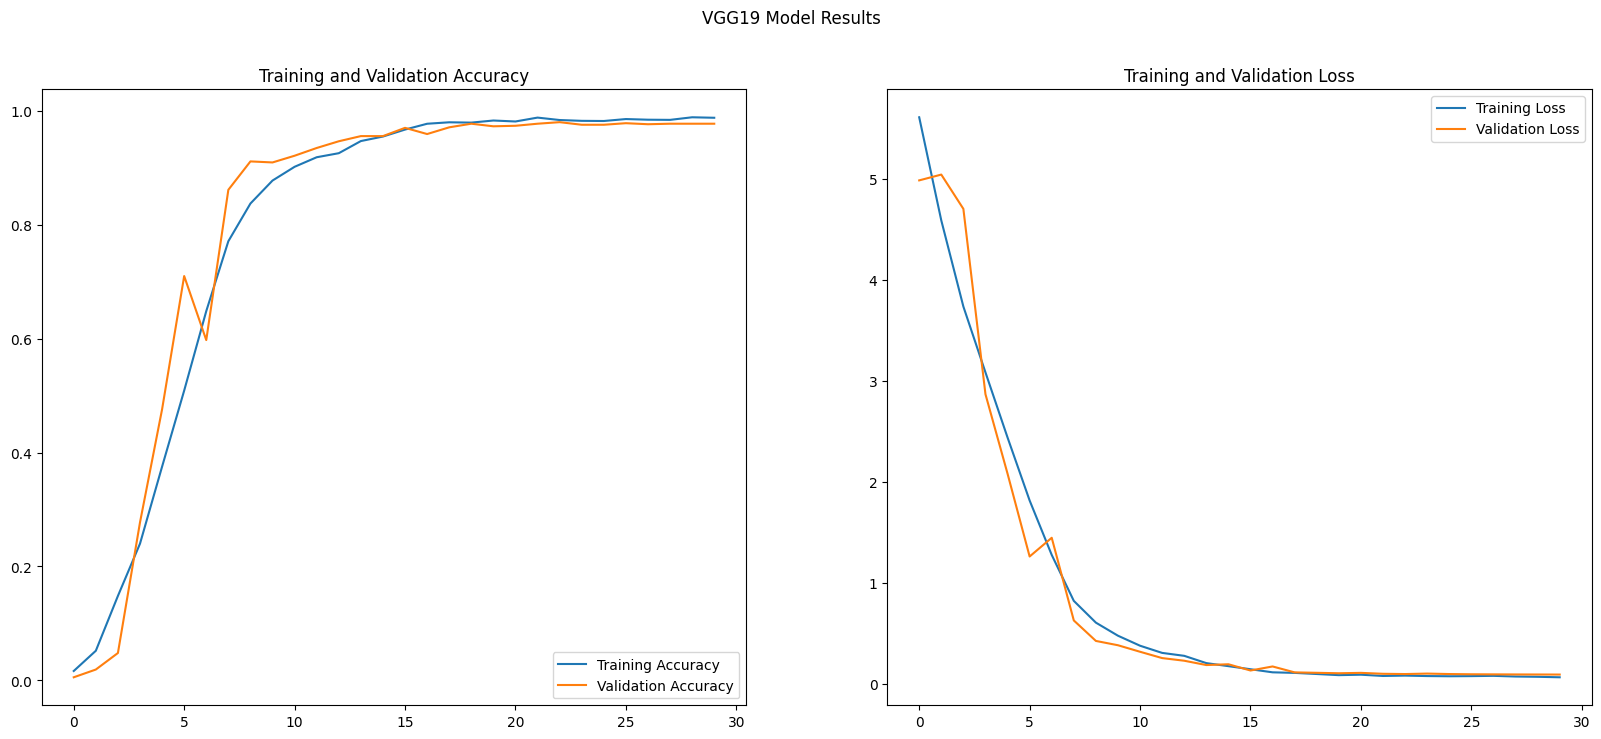

In [147]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

for name, history in model_histories.items():
    plot_model_performance(name, history)

In [148]:
for name, model in models.items():
    test_loss, test_accuracy = model[0].evaluate(test_dataset)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {test_accuracy*100:.2f}%")
    print(f"Test loss: {test_loss:.4f}", end = '\n\n')


27/27 [==============================] - 5s 65ms/step - loss: 0.0638 - accuracy: 0.9884
VGG19 Model Results:
Test accuracy: 98.84%
Test loss: 0.0638



Saving models and their training histories

In [142]:
for name, model in models.items():
    model[0].save(f'Saved Models/FYODB/{name}-{test_accuracy*100:.2f}%.keras')
    print(f'Saved {name} Model')

del history.history['lr']

for name, model in model_histories.items():
    with open(f'Model Histories/FYODB/{name}-{num_epochs}-epochs.json', 'w') as json_file:
        json.dump(history.history, json_file)


Saved VGG16 Model


In [143]:
# img = keras.utils.load_img(
#     "Full Data/roi/001-M/01/001_L_1_1.png", target_size=image_size
# )
# plt.imshow(img)

# img_array = keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)

# predictions = model.predict(img_array)
# predicted_class_index = tf.argmax(predictions[0]).numpy()
# print('Predicted Class:', predicted_class_index)